동물에게 해로운 식물을 분류하는 인공지능을 개발해보려고 한다. 이전에 만든 크롤러로 이미지를 수집한 후, 학습을 진행한다. 사용한 모듈은 넘파이, 텐서플로, 케라스, 맷플롯립을 사용했다.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import os

In [2]:
# 데이터 경로 설정
data_dir = "C:/temp/new_cat_plant_dataset"  # 실제 데이터 경로로 수정하세요

모델은 레즈넷을 사용하려고 한다. 이전 프로젝트에서 이미지 분류에 적합한 모델이었던 경험이 있었기 때문이다.
이미지 크기는 224*224로 하였다. 레즈넷50의 기본 입력 크기라고 한다. 자세한 내용은 공부를 더 해야할거 같다. 아직 모르는 내용이라 cloude에게 물어봤다.

In [3]:
# 이미지 크기 및 배치 크기 설정
img_height, img_width = 224, 224  # ResNet50의 기본 입력 크기
batch_size = 32

시간이 한정적이고 부족했던 상황이라 각 클래스 당 700장 정도 밖에 모으지 못했다. 그래서 증강을 하려고 한다. 회전, 좌우/상하 이동, 자르기, 확대, 상하 뒤집기 등을 했다. 우선은 cloude가 제안해준 대로 해본건데, 오히려 너무 많이 해서 결과가 좋지 않은 것 같다. 추후 수정을 해봐야할거 같다.

In [4]:
# 데이터 증강 및 제너레이터 생성
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

학습 데이터의 총 이미지 수는 약 2만개, 분류해야 하는 식물의 클래스 수는 47개이다. 나중에 더 추가해야 하지만, 지금은 이 정도로 한다.

In [5]:
# 학습 데이터 생성기
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 20760 images belonging to 47 classes.


검증 데이터 총 이미지 수는 약 5천개, 클래스 수는 동일하게 47개이다. 이 역시 나중에 더 추가할 예정이다.

In [6]:
# 검증 데이터 생성기
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 5175 images belonging to 47 classes.


In [7]:
# 클래스 수 확인
num_classes = len(train_generator.class_indices)
print(f"클래스 수: {num_classes}")
print("클래스 이름:", train_generator.class_indices)

클래스 수: 47
클래스 이름: {'Allium cepa': 0, 'Allium sativum': 1, 'Alocasia spp': 2, 'Aloe vera': 3, 'Anthurium spp': 4, 'Archontophoenix cunninghamiana': 5, 'Calendula officinalis': 6, 'Chamaedorea elegans': 7, 'Chrysanthemum spp': 8, 'Crassula ovata': 9, 'Cycas revoluta': 10, 'Cymbidium spp': 11, 'Dianthus caryophyllus': 12, 'Dicentra spectabilis': 13, 'Dieffenbachia spp': 14, 'Dracaena draco': 15, 'Dracaena fragrans': 16, 'Eucalyptus spp': 17, 'Fatsia japonica': 18, 'Ficus elastica': 19, 'Gypsophila paniculata': 20, 'Hedera helix': 21, 'Hippeastrum spp': 22, 'Hyacinthus orientalis': 23, 'Hydrangea spp': 24, 'Lilium spp': 25, 'Maranta leuconeura': 26, 'Monstera deliciosa': 27, 'Narcissus spp': 28, 'Nepeta cataria': 29, 'Pachira aquatica': 30, 'Paeonia spp': 31, 'Pelargonium graveolens': 32, 'Pittosporum tobira': 33, 'Platycodon grandiflorus': 34, 'Portulaca grandiflora': 35, 'Rhapis excelsa': 36, 'Rhododendron mucronulatum': 37, 'Rhododendron schlippenbachii': 38, 'Rosa spp': 39, 'Sansevieri

레즈넷50을 불러왔다.

In [8]:
# 전이 학습을 위한 기본 모델 로드
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [9]:
# 기본 모델 동결
for layer in base_model.layers:
    layer.trainable = False

모델은 다음과 같이 구성했다. 히든 레이어를 2개로 하여 렐루로 하였으며, 아웃풋 레이어는 소프트맥스로 설정했다.

In [10]:
# 새로운 분류기 추가
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation='softmax')(x)

In [11]:
# 최종 모델 생성
model = models.Model(inputs=base_model.input, outputs=output)

In [12]:
# 학습률 스케줄러 설정
initial_learning_rate = 0.001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)
optimizer = optimizers.Adam(learning_rate=lr_schedule)

In [13]:
# 모델 컴파일
model.compile(optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [14]:
checkpoint_filepath = 'C:\\temp.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

에포크는 30회 진행하였다.

In [15]:
# 모델 학습
epochs = 30
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
)

Epoch 1/30


c:\Users\gadi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


648/648 ━━━━━━━━━━━━━━━━━━━━ 4102s 6s/step - accuracy: 0.1456 - loss: 3.7911 - val_accuracy: 0.4076 - val_loss: 2.1245
Epoch 2/30
  1/648 ━━━━━━━━━━━━━━━━━━━━ 13:01 1s/step - accuracy: 0.0938 - loss: 3.1308

c:\Users\gadi2\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0938 - loss: 3.1308 - val_accuracy: 0.3913 - val_loss: 1.8386
Epoch 3/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 2779s 4s/step - accuracy: 0.3249 - loss: 2.5328 - val_accuracy: 0.4592 - val_loss: 1.9687
Epoch 4/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4688 - loss: 1.7207 - val_accuracy: 0.3913 - val_loss: 2.0597
Epoch 5/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 2724s 4s/step - accuracy: 0.3750 - loss: 2.2960 - val_accuracy: 0.4831 - val_loss: 1.8798
Epoch 6/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4688 - loss: 2.0587 - val_accuracy: 0.3478 - val_loss: 1.8341
Epoch 7/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 1761s 3s/step - accuracy: 0.4173 - loss: 2.1296 - val_accuracy: 0.5016 - val_loss: 1.7994
Epoch 8/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3750 - loss: 1.9328 - val_accuracy: 0.4783 - val_loss: 1.8928
Epoch 9/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 1717s 3s/step - accuracy: 0.4222 - loss: 2.1055 - val_accuracy: 0.502

학습 결과는 50%밖에 모델이 맞추지 못했다. 아무래도, 학습 데이터가 적기도 하고, 노이즈 데이터를 제거하는 전처리도 하나도 하지 않았기 때문인거 같다. 그것을 생각하면 오히려 점수가 잘 나온 것 같다. 역시 레즈넷 만세다.

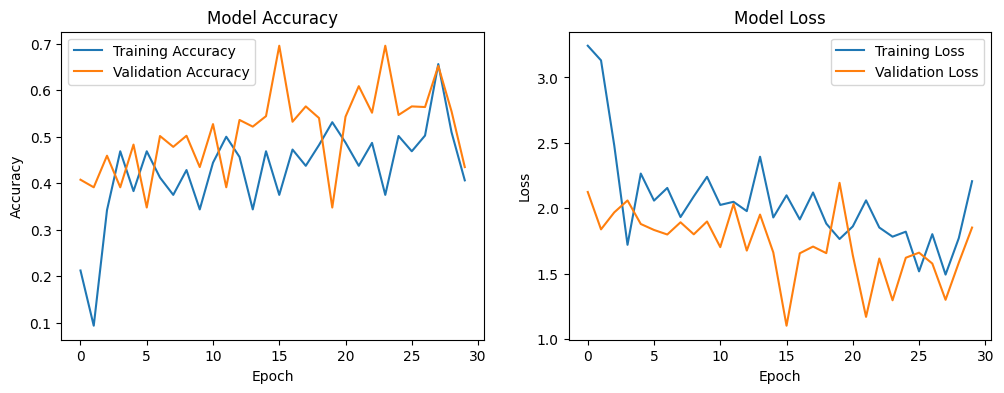

162/162 ━━━━━━━━━━━━━━━━━━━━ 596s 4s/step - accuracy: 0.5615 - loss: 1.5407
테스트 정확도: 0.55


In [16]:
# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 모델 저장
model.save('improved_plant_classification_model.h5')

# 모델 평가
test_loss, test_acc = model.evaluate(validation_generator)
print(f'테스트 정확도: {test_acc:.2f}')

모델 개선은 다음과 같이 해보려고 한다.
1. 데이터를 더 많이 수집해야한다.
2. 클래스 수도 더 많이 늘려야한다.
3. 노이즈 데이터를 전처리하고 데이터 정제하는 과정이 필요하다. 이를 위해 우선 소형 분류 모델을 만든 뒤, 크롤링한 데이터를 소형 분류 모델을 통해 정제하고, 이를 통해 다시 학습하는 과정을 반복하는 것으로 하려 한다.